In [1]:
import torch
import torch.nn.functional as F # for F.pad
from torch import nn

from torchvision.ops.misc import Permute
from torchvision.ops import StochasticDepth

import matplotlib.pyplot as plt
!pip install einops
from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 434.5 kB/s eta 0:00:00


In [2]:
class FeedForward(nn.Module):
    def __init__(self, dim, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(dim, d_ff),
                                    nn.GELU(),
                                    nn.Dropout(drop_p),
                                    nn.Linear(d_ff, dim))

    def forward(self, x):
        x = self.linear(x)
        return x

class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.dim = dim
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False) # merging 할 때 torch.cat으로 channel 축으로 쌓기 때문에 4dim이 된다
        self.norm = nn.LayerNorm(4*dim, eps=1e-5)

    def forward(self, x): # 개행열채
        H, W, _ = x.shape[1:]
        x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2)) # 홀수면 한줄 패딩 시킴, 채행열 기준 lr tb front back 순 이므로 행열채에 대해서는 front back lr tb 가 된다
        x0 = x[..., 0::2, 0::2, :]  # 1행 1열들
        x1 = x[..., 1::2, 0::2, :]  # 2행 1열들
        x2 = x[..., 0::2, 1::2, :]  # 1행 2열들
        x3 = x[..., 1::2, 1::2, :]  # 2행 2열들
        x = torch.cat([x0, x1, x2, x3], -1)  # 개 행/2 열/2 4채

        x = self.norm(x) # concat 하고 나서 바로 LN 하므로 (즉, 2x2 묶고 + channel 축 으로 normalization 한다) conv 로는 구현이 불가능! 그래서 nn.Linear로
        x = self.reduction(x)  # 개 행/2 열/2 2채
        return x

class ShiftedWindowAttention(nn.Module):
    def __init__(self, dim, window_size, shift_size, num_heads, drop_p = 0.0):
        super().__init__()

        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads

        self.fc_q = nn.Linear(dim, dim)
        self.fc_k = nn.Linear(dim, dim)
        self.fc_v = nn.Linear(dim, dim)
        self.fc_o = nn.Linear(dim, dim)

        self.scale = torch.sqrt(torch.tensor(dim / num_heads))

        self.get_relative_position_bias()

    def get_relative_position_bias(self):

        B_hat = nn.Parameter(torch.zeros(self.num_heads, (2 * self.window_size[0] - 1), (2 * self.window_size[1] - 1)))
        nn.init.trunc_normal_(B_hat, std=0.02)

        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        H, W = torch.meshgrid(coords_h, coords_w)

        relative_coords_h = H.reshape(1,-1) - H.reshape(-1,1)
        relative_coords_w = W.reshape(1,-1) - W.reshape(-1,1)
        relative_position_index_h = relative_coords_h.flatten() + self.window_size[0] - 1 # 인덱스가 0부터 시작하도록 6을 더해줌 (즉, "나"의 좌표는 (6,6)임)
        relative_position_index_w = relative_coords_w.flatten() + self.window_size[1] - 1

        N = self.window_size[0] * self.window_size[1]
        self.B = B_hat[:, relative_position_index_h, relative_position_index_w]
        self.B = self.B.view(-1, N, N).unsqueeze(0)

    def forward(self, x):

        M0, M1 = self.window_size
        B, H, W, C = x.shape # 개행열채

        # window size의 배수가 되도록 padding
        pad_r = (M1 - W % M1) % M1
        pad_b = (M0 - H % M0) % M0
        x = F.pad(x, (0, 0, 0, pad_r, 0, pad_b)) # 채행열 기준 lr tb front back 순 이므로 행열채에 대해서는 front back lr tb 가 된다
        _, pad_H, pad_W, _ = x.shape

        # down sample 많이 돼서 window size보다 resolution이 더 작으면 shift 할 필요 없음
        shift_size = self.shift_size.copy()
        if pad_H <= M0:
            shift_size[0] = 0
        if pad_W <= M1:
            shift_size[1] = 0

        # cyclic shift
        if sum(shift_size) > 0:
            x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))

        # MSA
        x = rearrange(x, '개 (윈0 M0) (윈1 M1) 차 -> 개 (윈0 윈1) (M0 M1) 차', M0=M0, M1=M1) # 개행열채 -> 개윈단차

        Q = self.fc_q(x) # 개윈단차
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = rearrange(Q, '개 윈 단 (헤 차) -> 개 윈 헤 단 차', 헤 = self.num_heads) # 개윈단차 -> 개윈헤단차
        K = rearrange(K, '개 윈 단 (헤 차) -> 개 윈 헤 단 차', 헤 = self.num_heads)
        V = rearrange(V, '개 윈 단 (헤 차) -> 개 윈 헤 단 차', 헤 = self.num_heads)

        attn = Q @ K.transpose(-2,-1)/self.scale # 개윈헤단단

        # add relative position bias
        attn = attn + self.B

        # generate attention mask
        if sum(shift_size) > 0:
            attn_mask = x.new_zeros(pad_H, pad_W) # x와 같은 데이터 타입과 디바이스에 올려진, pad_H 행 x pad_W 열인 행렬을 만듦
            h_slices = ((0, -M0), (-M0, -shift_size[0]), (-shift_size[0], None))
            w_slices = ((0, -M1), (-M1, -shift_size[1]), (-shift_size[1], None))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    attn_mask[h[0] : h[1], w[0] : w[1]] = count
                    count += 1
            attn_mask = rearrange(attn_mask, '(윈0 M0) (윈1 M1) -> (윈0 윈1) (M0 M1)', M0=M0, M1=M1)
            attn_mask = attn_mask.unsqueeze(2) - attn_mask.unsqueeze(1) # 9 x 49 x 49
            attn_mask[attn_mask != 0] = -1e10
            attn = attn + attn_mask.unsqueeze(1).unsqueeze(0) # + 1 9 1 49 49

        attn = F.softmax(attn, dim=-1) # 개윈헤단단

        attn = attn @ V # 개윈헤단차

        x = rearrange(attn, '개 윈 헤 단 차 -> 개 윈 단 (헤 차)') # 개윈헤단차 -> 개윈단차
        x = self.fc_o(x) # 개윈단차

        x = rearrange(x, '개 (윈0 윈1) (M0 M1) 차 -> 개 (윈0 M0) (윈1 M1) 차', 윈0=pad_H//M0, M0=M0) # 개윈단차 -> 개행열채

        # reverse cyclic shift
        if sum(shift_size) > 0:
            x = torch.roll(x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))

        # unpad features
        x = x[:, :H, :W, :]

        return x

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size, mlp_ratio = 4.0, drop_p = 0.0, stochastic_depth_prob = 0.0):
        super().__init__()

        self.SW_MSA_LN = nn.LayerNorm(dim, eps=1e-5)
        self.SW_MSA = ShiftedWindowAttention(dim, window_size, shift_size, num_heads, drop_p=drop_p)

        self.FF_LN = nn.LayerNorm(dim, eps=1e-5)
        self.FF = FeedForward(dim, int(dim * mlp_ratio), drop_p=drop_p)

        self.dropout = nn.Dropout(drop_p)
        self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")

        for m in self.FF.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def forward(self, x):

        residual = self.SW_MSA_LN(x)
        residual = self.SW_MSA(residual)
        residual = self.dropout(residual)
        residual = self.stochastic_depth(residual)
        x = x + residual

        residual = self.FF_LN(x)
        residual = self.FF(residual)
        residual = self.dropout(residual)
        residual = self.stochastic_depth(residual)
        x = x + residual

        return x

class SwinTransformer(nn.Module):
    def __init__(self, patch_size, embed_dim, depths, num_heads, window_size, mlp_ratio = 4, drop_p = 0.0, stochastic_depth_prob = 0.1, num_classes = 1000):
        super().__init__()

        self.num_classes = num_classes

        layers = []
        # split image into non-overlapping patches
        layers += [nn.Sequential(nn.Conv2d(3, embed_dim, kernel_size=(patch_size[0], patch_size[1]), stride=(patch_size[0], patch_size[1])),
                                 Permute([0, 2, 3, 1]), # 여기서 개행열채로 바뀜. torch.permute() 를 쓰려면 forward 에서 해야하기 때문에 nn.Sequential() 안에 넣으려면 이렇게!
                                 nn.LayerNorm(embed_dim, eps=1e-5))]

        total_stage_blocks = sum(depths)
        stage_block_id = 0
        # build SwinTransformer blocks
        for i_stage in range(len(depths)):
            stage = []
            dim = embed_dim * 2**i_stage
            for i_layer in range(depths[i_stage]):
                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = stochastic_depth_prob * stage_block_id / (total_stage_blocks - 1)
                stage += [SwinTransformerBlock(dim,
                                               num_heads[i_stage],
                                               window_size=window_size,
                                               shift_size=[0 if i_layer % 2 == 0 else w // 2 for w in window_size], # 한 번은 W-MSA, 한 번은 SW-MSA
                                               mlp_ratio=mlp_ratio,
                                               drop_p = drop_p,
                                               stochastic_depth_prob=sd_prob)]
                stage_block_id += 1
            layers += [nn.Sequential(*stage)]
            # add patch merging layer
            # https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py#L590 참고
            # Stage 구성이 그림에서 Partition - [[ Linear Embedding - Swin Block ]] 이렇게 묶여있는데 코드에서는
            # 첫 conv - [[ Swin Block - Path Merging ]] 이렇게 묶이게끔 짜여져 있다)
            if i_stage < (len(depths) - 1):
                layers += [PatchMerging(dim)]
        self.features = nn.Sequential(*layers)

        # https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py#L595 참고
        # LN - GAP - fc 로 되어있음.
        # ViT의 실험 중 CLS 토큰 안 쓰고 최종 인코더 아웃풋에 GAP-fc 하는 방식을 Swin 에서는 기본 구조로 채택함!
        num_features = embed_dim * 2 ** (len(depths) - 1)
        self.norm = nn.LayerNorm(num_features, eps=1e-5)
        self.avgpool = nn.Sequential(Permute([0, 3, 1, 2]), # 개행열채 -> 개채행열
                                     nn.AdaptiveAvgPool2d((1,1)))
        self.fc = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.norm(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [3]:
def swin_t(**kwargs): # 28288354
    return SwinTransformer(patch_size=[4, 4], embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=[7, 7], stochastic_depth_prob=0.2, **kwargs)

def swin_s(**kwargs): # 49606258
    return SwinTransformer(patch_size=[4, 4], embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24], window_size=[7, 7], stochastic_depth_prob=0.3, **kwargs)

def swin_b(**kwargs): # 87768224
    return SwinTransformer(patch_size=[4, 4], embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32], window_size=[7, 7], stochastic_depth_prob=0.5, **kwargs)

In [4]:
model = swin_t()
!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(2,3,224,224), device='cpu')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [2, 1000]                 --
├─Sequential: 1-1                                  [2, 7, 7, 768]            --
│    └─Sequential: 2-1                             [2, 56, 56, 96]           --
│    │    └─Conv2d: 3-1                            [2, 96, 56, 56]           4,704
│    │    └─Permute: 3-2                           [2, 56, 56, 96]           --
│    │    └─LayerNorm: 3-3                         [2, 56, 56, 96]           192
│    └─Sequential: 2-2                             [2, 56, 56, 96]           --
│    │    └─SwinTransformerBlock: 3-4              [2, 56, 56, 96]           111,840
│    │    └─SwinTransformerBlock: 3-5              [2, 56, 56, 96]           111,840
│    └─PatchMerging: 2-3                           [2, 28, 28, 192]          --
│    │    └─LayerNorm: 3-6                         [2, 28, 28, 384]          768
│    │    └─Linear: 

In [5]:
x = torch.randn(2,3,224,224)
print(model(x).shape)

torch.Size([2, 1000])


In [6]:
model.train()
print(model(x))
print(model(x))
model.eval()
print(model(x))
print(model(x))

tensor([[ 0.2381,  0.1704, -0.1430,  ...,  0.0259,  0.0241, -0.0719],
        [ 0.0973,  0.1863, -0.0194,  ...,  0.0294, -0.3206, -0.2082]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0721,  0.1207, -0.1582,  ..., -0.1540,  0.0927, -0.0659],
        [-0.0577,  0.3605, -0.2198,  ..., -0.0536, -0.0039, -0.1544]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1158,  0.1885, -0.1978,  ..., -0.0975, -0.0225, -0.0975],
        [ 0.0313,  0.1440, -0.1592,  ..., -0.0538, -0.1705, -0.3077]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1158,  0.1885, -0.1978,  ..., -0.0975, -0.0225, -0.0975],
        [ 0.0313,  0.1440, -0.1592,  ..., -0.0538, -0.1705, -0.3077]],
       grad_fn=<AddmmBackward0>)


In [7]:
# F.pad 실험
input = torch.randn(1, 5, 5, 3) # 개행열채
pad_r = 2
pad_b = 1
output = F.pad(input, (0, 0, 0, pad_r, 0, pad_b))
# pad size 는 left right (열) top bottom (행) front back (채) 순인데 채행열로 들어온다고 생각하기 때문에 행열채로 되어있는 현재 상황을 잘 생각해줘야..
# 즉, front back lr tb 순이 된다!

print(output.shape)

torch.Size([1, 6, 7, 3])


In [8]:
# pad_r, pad_b 가 어떻게 계산되는건지
M0, M1 = [7,7]
W = 3
H = 3
pad_r = (M1 - W % M1) % M1
pad_b = (M0 - H % M0) % M0
print(pad_r)
print(pad_b)

pad_r = (M1 - W % M1) # 배수 일 때는 pad=0 이여야 해서 마지막에 %M1 가 붙어야 함
pad_b = (M0 - H % M0)
print(pad_r)
print(pad_b)

4
4
4
4


In [9]:
# torch.roll 실험
x = torch.randint(0,6, (1,5,5,1))
print(x.squeeze())

shifted_x = torch.roll(x, shifts=(2, 0), dims=(1, 2)) # 아래로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(-2, 0), dims=(1, 2)) # 위로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(0, 2), dims=(1, 2)) # 오른쪽으로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(0, -2), dims=(1, 2)) # 왼쪽으로 두칸 이동
print(shifted_x.squeeze())

shifted_x = torch.roll(x, shifts=(-2, -2), dims=(1, 2)) # 왼쪽 위로 두칸씩 이동
print(shifted_x.squeeze())

tensor([[1, 1, 4, 5, 3],
        [2, 1, 3, 3, 3],
        [0, 0, 0, 1, 4],
        [3, 5, 3, 4, 4],
        [2, 1, 5, 0, 0]])
tensor([[3, 5, 3, 4, 4],
        [2, 1, 5, 0, 0],
        [1, 1, 4, 5, 3],
        [2, 1, 3, 3, 3],
        [0, 0, 0, 1, 4]])
tensor([[0, 0, 0, 1, 4],
        [3, 5, 3, 4, 4],
        [2, 1, 5, 0, 0],
        [1, 1, 4, 5, 3],
        [2, 1, 3, 3, 3]])
tensor([[5, 3, 1, 1, 4],
        [3, 3, 2, 1, 3],
        [1, 4, 0, 0, 0],
        [4, 4, 3, 5, 3],
        [0, 0, 2, 1, 5]])
tensor([[4, 5, 3, 1, 1],
        [3, 3, 3, 2, 1],
        [0, 1, 4, 0, 0],
        [3, 4, 4, 3, 5],
        [5, 0, 0, 2, 1]])
tensor([[0, 1, 4, 0, 0],
        [3, 4, 4, 3, 5],
        [5, 0, 0, 2, 1],
        [4, 5, 3, 1, 1],
        [3, 3, 3, 2, 1]])


torch.Size([21, 21])


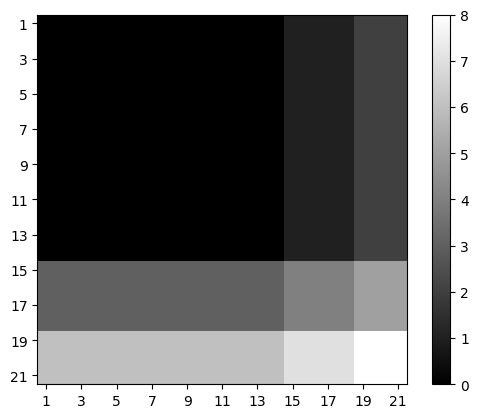

In [10]:
# 그룹 번호 매기기
M0, M1 = [7, 7]
shift_size = [3, 3]
pad_H = pad_W = 21
# num_windows = (pad_H // M0) * (pad_W // M1)

attn_mask = torch.zeros(pad_H, pad_W)
h_slices = ((0, -M0), (-M0, -shift_size[0]), (-shift_size[0], None))
w_slices = ((0, -M1), (-M1, -shift_size[1]), (-shift_size[1], None))
count = 0
for h in h_slices:
    for w in w_slices:
        attn_mask[h[0] : h[1], w[0] : w[1]] = count
        count += 1

print(attn_mask.shape)
plt.figure()
plt.imshow(attn_mask, cmap='gray')
plt.xticks(range(0,pad_W,2), range(1,pad_W+1,2))
plt.yticks(range(0,pad_H,2), range(1,pad_H+1,2))
plt.colorbar()
plt.show()

In [11]:
# 각 번호 별로(행) mask 만들기 (열)
attn_mask = rearrange(attn_mask, '(윈0 M0) (윈1 M1) -> (윈0 윈1) (M0 M1)', M0=M0, M1=M1)
print(attn_mask.shape)
print(attn_mask)
attn_mask = attn_mask.unsqueeze(2) - attn_mask.unsqueeze(1)
print(attn_mask.shape)
attn_mask[attn_mask != 0] = -100

torch.Size([9, 49])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1.,
         2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 1.,
         1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

In [12]:
# 윗 셀에서 attn_mask.unsqueeze(2) - attn_mask.unsqueeze(1) 어떤 식으로 빼지는 건지 확인
attn_mask_test = torch.tensor([[0, 0, 0, 0], [1, 2, 1, 2], [3, 3, 6, 6], [4, 5, 7, 8]])
expanded_attn_mask = attn_mask_test.unsqueeze(2) - attn_mask_test.unsqueeze(1)
print(attn_mask_test)
print(attn_mask_test.unsqueeze(2))
print(attn_mask_test.unsqueeze(1))
print(expanded_attn_mask)

tensor([[0, 0, 0, 0],
        [1, 2, 1, 2],
        [3, 3, 6, 6],
        [4, 5, 7, 8]])
tensor([[[0],
         [0],
         [0],
         [0]],

        [[1],
         [2],
         [1],
         [2]],

        [[3],
         [3],
         [6],
         [6]],

        [[4],
         [5],
         [7],
         [8]]])
tensor([[[0, 0, 0, 0]],

        [[1, 2, 1, 2]],

        [[3, 3, 6, 6]],

        [[4, 5, 7, 8]]])
tensor([[[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        [[ 0, -1,  0, -1],
         [ 1,  0,  1,  0],
         [ 0, -1,  0, -1],
         [ 1,  0,  1,  0]],

        [[ 0,  0, -3, -3],
         [ 0,  0, -3, -3],
         [ 3,  3,  0,  0],
         [ 3,  3,  0,  0]],

        [[ 0, -1, -3, -4],
         [ 1,  0, -2, -3],
         [ 3,  2,  0, -1],
         [ 4,  3,  1,  0]]])


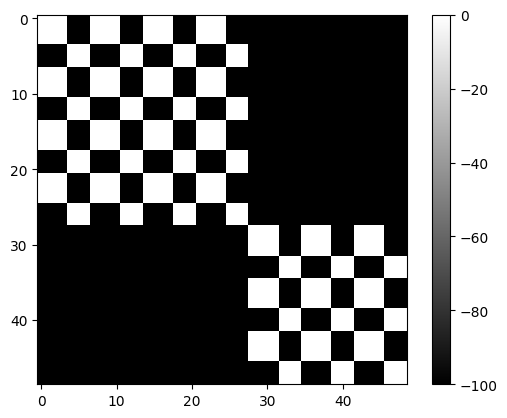

In [13]:
# 0~8 번째 윈도우까지 (한 픽셀 기준으로 나머지 49개 픽셀에 대해서 누구랑 attention 해야할 지가 하얗게 나온다 => 같은 번호 받은 애들과만 attention!)
plt.figure()
plt.imshow(attn_mask[8], cmap='gray')
plt.colorbar()
plt.show()

In [14]:
# relative position bias 만들기
window_size = (7,7)

coords_h = torch.arange(window_size[0])
coords_w = torch.arange(window_size[1])

H, W = torch.meshgrid(coords_h, coords_w)
print(H)
print(W)

tensor([[0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6]])
tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])


In [15]:
# relative position bias 만들기 (continued)
relative_coords_h = H.reshape(1,-1) - H.reshape(-1,1)
relative_coords_w = W.reshape(1,-1) - W.reshape(-1,1)

print(H.reshape(1,-1))
print(H.reshape(-1,1))
print(relative_coords_h)
print(relative_coords_w)
print(relative_coords_h.shape)
print(relative_coords_w.shape)

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6]])
tensor([[ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6],
        [ 0,  0,  0,  ...,  6,  6,  6],
        ...,
        [-6, -6, -6,  ...,  0,  0,  0],
        [-6, 

In [16]:
# relative position bias 만들기 (continued)
relative_position_index_h = relative_coords_h.flatten() + window_size[0] - 1 # 인덱스가 0부터 시작하도록 6을 더해줌 (즉, "나"의 좌표는 (6,6)임)
relative_position_index_w = relative_coords_w.flatten() + window_size[1] - 1

print(relative_position_index_h)
print(relative_position_index_w)

tensor([6, 6, 6,  ..., 6, 6, 6])
tensor([6, 7, 8,  ..., 4, 5, 6])


In [17]:
# relative position bias 만들기 (continued)
B_hat = nn.Parameter(torch.zeros(4, (2 * window_size[0] - 1), (2 * window_size[1] - 1))) # 4 는 num_heads가 올자리
nn.init.trunc_normal_(B_hat, std=0.02)

B = B_hat[:, relative_position_index_h, relative_position_index_w]
B = B.view(-1, 49, 49).unsqueeze(0) # N = 49

print(B.shape)
print(B)

torch.Size([1, 4, 49, 49])
tensor([[[[ 0.0059, -0.0427, -0.0322,  ..., -0.0225, -0.0209,  0.0529],
          [ 0.0072,  0.0059, -0.0427,  ...,  0.0222, -0.0225, -0.0209],
          [ 0.0011,  0.0072,  0.0059,  ...,  0.0072,  0.0222, -0.0225],
          ...,
          [ 0.0264,  0.0015, -0.0439,  ...,  0.0059, -0.0427, -0.0322],
          [-0.0295,  0.0264,  0.0015,  ...,  0.0072,  0.0059, -0.0427],
          [-0.0218, -0.0295,  0.0264,  ...,  0.0011,  0.0072,  0.0059]],

         [[ 0.0178, -0.0175,  0.0169,  ...,  0.0139,  0.0253, -0.0084],
          [-0.0137,  0.0178, -0.0175,  ..., -0.0100,  0.0139,  0.0253],
          [ 0.0054, -0.0137,  0.0178,  ..., -0.0188, -0.0100,  0.0139],
          ...,
          [-0.0174, -0.0082,  0.0063,  ...,  0.0178, -0.0175,  0.0169],
          [-0.0059, -0.0174, -0.0082,  ..., -0.0137,  0.0178, -0.0175],
          [-0.0148, -0.0059, -0.0174,  ...,  0.0054, -0.0137,  0.0178]],

         [[ 0.0152,  0.0054, -0.0056,  ..., -0.0101, -0.0023, -0.0036],
   

In [18]:
# B_hat 과 비교 확인
print(B[0,0,0,0])
print(B_hat[0,6,6]) # 자기 자신과 내적에 대한 bias는 B_hat의 6,6에 존재

print(B[0,0,0,1])
print(B_hat[0,6,7]) # 한칸 오른쪽, 한칸 아래는 B_hat의 6,7에 존재

print(B[0,0,0,7]) # 맨 윗줄이 0~6 이므로 한 칸 아래는 7 번째
print(B_hat[0,7,6]) # 한칸 아래는 B_hat의 7,6에 존재

tensor(0.0059, grad_fn=<SelectBackward0>)
tensor(0.0059, grad_fn=<SelectBackward0>)
tensor(-0.0427, grad_fn=<SelectBackward0>)
tensor(-0.0427, grad_fn=<SelectBackward0>)
tensor(0.0132, grad_fn=<SelectBackward0>)
tensor(0.0132, grad_fn=<SelectBackward0>)
